<a href="https://colab.research.google.com/github/satoru2001/Pneumonia_Classification/blob/master/ChestXray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authenticating and Downloading Dataset from Kaggle

In [1]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 37.3MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.4MB/s]


# Extracting Data

In [5]:
import zipfile 
ref = '/content/chest-xray-pneumonia.zip'
zip_ref = zipfile.ZipFile(ref,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Visualizing Images from training

In [103]:
import matplotlib.pyplot as plt
def plot_example_images(plt,condition):
  img_size = 300
  plt.figure(0,figsize=(12,20))
  ctr = 0
  for i in range(1,6):
    ctr+=1
    plt.subplot(1,5,ctr)
    img = load_img("/tmp/chest_xray/train/" + condition + "/" +os.listdir("/tmp/chest_xray/train/" + condition)[i], target_size=(img_size, img_size))
    plt.imshow(img)
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

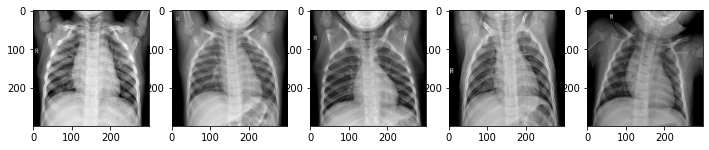

In [104]:
plot_example_images(plt,'NORMAL')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

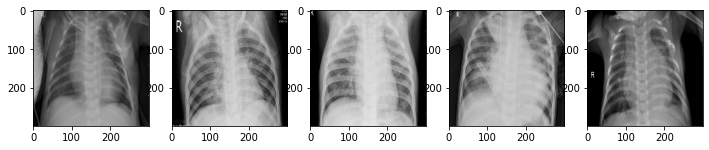

In [105]:
plot_example_images(plt,'PNEUMONIA')

# Checking the sizes of images

In [49]:
dir = '/tmp/chest_xray/test/NORMAL'
list_img = os.listdir(dir)[:10]
for i in list_img:
  img  = load_img(dir+'/'+i)
  img = img_to_array(img)
  print(img.shape)

(1709, 2096, 3)
(1282, 1788, 3)
(1945, 2214, 3)
(1224, 1752, 3)
(1202, 1538, 3)
(1187, 1624, 3)
(2458, 2720, 3)
(1016, 1432, 3)
(1317, 1857, 3)
(1041, 1616, 3)


# Applying Transfer Learning by using Xception Model

In [12]:
import os
import tensorflow
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D,BatchNormalization,Dropout,Flatten,MaxPool2D,Lambda,Activation,AveragePooling2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [80]:
from tensorflow.keras.applications.xception import Xception,preprocess_input
pretrained = Xception(include_top=False,weights='imagenet',pooling='max',input_shape=(799,799,3))
x = pretrained.output

In [81]:
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1,activation='sigmoid')(x)
model = Model(inputs=pretrained.input,outputs=x)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

# Call Backs for
- To stop training when an accuracy of 99% Reached
- To decrease Learning rate if previous 2 epochs val_loss is not changed
- To store maximum val_accuracy weights

In [94]:
decay_lr = ReduceLROnPlateau(factor=0.001,patience=3,min_lr=0.000001)
checkpoint = ModelCheckpoint('model_weights.h5',save_best_only=True,save_weights_only=True,mode='max')
class myCallBack(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('accuracy')>0.99):
      print("\n99% accuracy so cancelling training!")
      self.model.stop_training = True
stop_train = myCallBack()
callbacks = [decay_lr,checkpoint,stop_train]

In [83]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 799, 799, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 399, 399, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 399, 399, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 399, 399, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

# Data Generators

In [100]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
)
train_gen = train_datagen.flow_from_directory(
    '/tmp/chest_xray/train',
    target_size=(799,799),
    class_mode = 'binary',
    batch_size=4,
)

valid_gen =  train_datagen.flow_from_directory(
    '/tmp/chest_xray/val',
    target_size=(799,799),
    class_mode = 'binary',
    batch_size=4,
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(train_gen,epochs=2,callbacks=callbacks,validation_data=valid_gen)

### I accidentally deleted the output of model.fit. It takes ~60min for 1 epoch
### To produce train,validation accuracy I will run model.evaluate on them
### Validation accuracy will be less because of provided validation dataset is too low 16 images

In [99]:
model.evaluate(train_gen)

1304/1304 [==============================] - 737s 565ms/step - loss: 0.1281 - accuracy: 0.9787


[0.1280757188796997, 0.9787193536758423]

In [101]:
model.evaluate(valid_gen)

4/4 [==============================] - 2s 421ms/step - loss: 1.7350 - accuracy: 0.6250


[1.7349544763565063, 0.625]

# Loading and evaluating on Test set

In [95]:
test_gen =  train_datagen.flow_from_directory(
    '/tmp/chest_xray/test',
    target_size=(799,799),
    class_mode = 'binary',
    batch_size=1,
)

Found 624 images belonging to 2 classes.


In [97]:
predict_model = Model(pretrained.input,x)
predict_model.load_weights('model_weights.h5')
predict_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [98]:
predict_model.evaluate(test_gen)

624/624 [==============================] - 98s 157ms/step - loss: 0.8196 - accuracy: 0.7484


[0.8195906281471252, 0.7483974099159241]